# 0. Setup

In [2]:
import pathlib
import os
import pandas as pd

In [3]:
# Load preprocessed loan data
def load_loan_data():
    ROOT_PATH = pathlib.Path().resolve().parent
    raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
    print(f"🔍 Checking for file at path: {raw_data_path}")

    if os.path.exists(raw_data_path):
        data = pd.read_csv(raw_data_path)
        print("✅ Data loaded successfully")
        return data
    else:
        raise FileNotFoundError(f"The file {raw_data_path} does not exist. Please check the path.")

In [4]:
# Load data
data = load_loan_data()

data.tail(10)

🔍 Checking for file at path: /Users/giliamo/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv
✅ Data loaded successfully


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
148660,173550,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,CIB,851,EXP,45-54,not_inst,55.699088,North,direct,0,20.0
148661,173551,2019,cf,Sex Not Available,nopre,type2,p4,l1,nopc,b/c,...,EXP,585,CIB,25-34,to_inst,96.787710,south,direct,1,NaN
148662,173552,2019,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,...,CIB,873,EXP,45-54,not_inst,78.079710,North,direct,0,31.0
148663,173553,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,619,EXP,<25,to_inst,NaN,North,direct,1,NaN
148664,173554,2019,cf,Joint,nopre,type2,p1,l1,nopc,b/c,...,EXP,859,EXP,65-74,to_inst,99.050633,central,direct,0,45.0
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0
148669,173559,2019,cf,Female,nopre,type1,p3,l1,nopc,nob/c,...,CIB,830,CIB,45-54,not_inst,72.849462,North,direct,0,44.0


In [5]:
import sys
import os

# Navigate one level up to reach the main project directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Import the function from preprocessor.py in package_folder
from package_folder.preprocessor_light import create_preprocessing_pipeline

In [6]:
# Apply the preprocessor
pipeline = create_preprocessing_pipeline()
data_processed = pipeline.fit_transform(data)

✅ Data cleaned
✅ Columns 'year' and 'ID' dropped
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Outliers removed based on IQR threshold
✅ Continuous variables scaled between 0 and 1


In [7]:
data_processed.head()

,loan_amount,rate_of_interest,Interest_rate_spread,property_value,income,Credit_Score,LTV,Status,dtir1,loan_limit_cf,...,age_<25,age_>74,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,0.087719,0.512993,0.506896,0.066225,0.082386,0.6450,0.679944,1.0,0.714286,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.166667,0.512993,0.506896,0.317810,0.235795,0.1300,0.495235,1.0,0.584517,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.342105,0.660000,0.426611,0.324503,0.448864,0.8350,0.546940,0.0,0.732143,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.385965,0.571429,0.586412,0.423841,0.562500,0.2175,0.471280,0.0,0.660714,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.596491,0.500000,0.461229,0.490066,0.494318,0.2550,0.631302,0.0,0.607143,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 1. Prepare the Data

In [8]:
# Step 1: General information about the dataset
print("Data Info:")
print(data_processed.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the data:")
print(data_processed.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 143802 entries, 0 to 148669
Data columns (total 95 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amount                         143802 non-null  float64
 1   rate_of_interest                    143802 non-null  float64
 2   Interest_rate_spread                143802 non-null  float64
 3   property_value                      143802 non-null  float64
 4   income                              143802 non-null  float64
 5   Credit_Score                        143802 non-null  float64
 6   LTV                                 143802 non-null  float64
 7   Status                              143802 non-null  float64
 8   dtir1                               143802 non-null  float64
 9   loan_limit_cf                       143802 non-null  float64
 10  loan_limit_ncf                      143802 non-null  float64
 11  Gender_Female       

In [9]:
# Define target variable and features
target_column = 'Status'
X = data_processed.drop(columns=[target_column])
y = data_processed[target_column]

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Check target distribution
print("Training set target distribution:")
print(y_train.value_counts())

print("Test set target distribution:")
print(y_test.value_counts())

Training set target distribution:
Status
0.0    86628
1.0    28413
Name: count, dtype: int64
Test set target distribution:
Status
0.0    21670
1.0     7091
Name: count, dtype: int64


Distribution of Status:
Status
0.0    75.310496
1.0    24.689504
Name: proportion, dtype: float64

Summary statistics by Status (mean):
        loan_amount  rate_of_interest  Interest_rate_spread  property_value  \
Status                                                                        
0.0        0.272899          0.511357              0.507670        0.302759   
1.0        0.252496          0.513484              0.506896        0.283490   

          income  Credit_Score       LTV     dtir1  loan_limit_cf  \
Status                                                              
0.0     0.315019      0.498764  0.494188  0.582645       0.945752   
1.0     0.265608      0.501578  0.512028  0.605356       0.922882   

        loan_limit_ncf  ...   age_<25   age_>74  \
Status                  ...                       
0.0           0.054248  ...  0.008569  0.044488   
1.0           0.077118  ...  0.010731  0.058444   

        submission_of_application_not_inst  submission_of_applica

ValueError: Could not interpret value `loan_limit_cf` for `y`. An entry with this name does not appear in `data`.

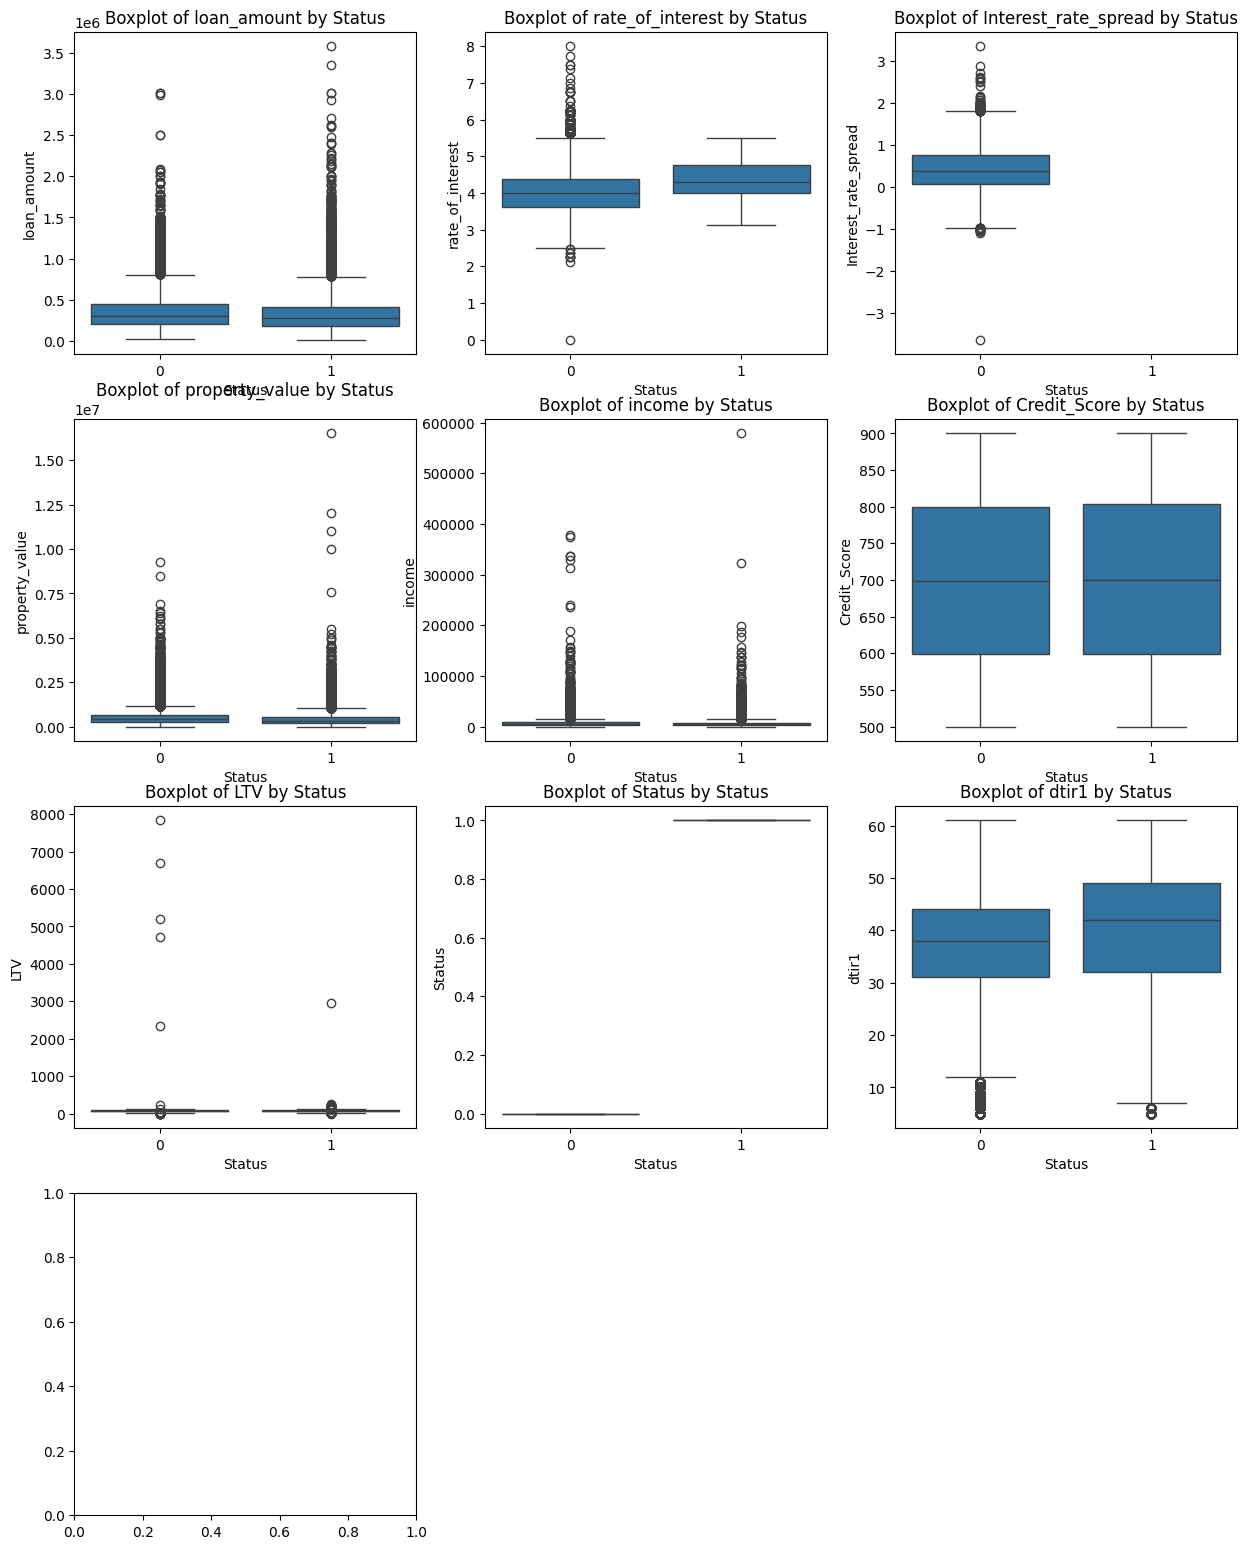

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 1. Distribution of the target variable `Status`
print("Distribution of Status:")
print(data_processed['Status'].value_counts(normalize=True) * 100)

# 2. Summary statistics for numerical variables by `Status`
print("\nSummary statistics by Status (mean):")
print(data_processed.groupby('Status').mean())

# 3. Additional statistical measures like median and standard deviation
print("\nMedian by Status:")
print(data_processed.groupby('Status').median())
print("\nStandard deviation by Status:")
print(data_processed.groupby('Status').std())

# 4. Visualization: Boxplots for numerical variables
numeric_columns = data_processed.select_dtypes(include=['float64', 'int64']).columns
num_numeric_columns = len(numeric_columns)
num_rows = math.ceil(num_numeric_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(x='Status', y=col, data=data)
    plt.title(f'Boxplot of {col} by Status')
plt.tight_layout()
plt.show()

# 5. Visualization: Countplots for categorical variables
categorical_columns = data_processed.select_dtypes(include=['object']).columns
num_categorical_columns = len(categorical_columns)
num_rows = math.ceil(num_categorical_columns / 3)

plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.countplot(x=col, hue='Status', data=data_processed)
    plt.title(f'Countplot of {col} by Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Model Selection and Initial Tests

**Why is Recall particularly important?**


In loan default prediction, the goal is to identify loans that might default (class `1`) so that actions can be taken, such as conducting additional checks or setting stricter requirements for these applicants. Recall for the default class (class `1`) is crucial here because:
1. Recall measures the model's ability to detect actual defaults: A high recall value means the model is capturing a large portion of true defaults, reducing the risk of "false negatives" (loans that default but are predicted as safe).
2. Minimizing costs and risks: False negatives can be costly for a bank or lending institution, as undetected defaults could lead to significant financial losses. Recall helps mitigate this risk.

**How does Recall differ from Precision?**


1. Recall: Measures the proportion of actual defaults that were correctly identified by the model. It answers the question: How many of the true defaults did the model detect?
2. Precision: Measures the proportion of predicted defaults that are actual defaults. It answers: How reliable are the default predictions?
While Precision is also valuable, in this case, it's often more desirable to have a model that over-identifies defaults rather than misses them (higher Recall).

**Models that are suitable for high Recall**
1. Random Forest
2. Gradient Boosting 
3. Logistic Regression
4. Support Vector Machines
5. Naive Bayes

Checking the target distribution helps us to make an informed decision about the balancing strategy and to ensure that our model is trained and tested fairly. Depending on the distribution, we then decide whether a simple balancing or a stronger adjustment (e.g. SMOTE) is necessary.

In [13]:
data = data_processed

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define target variable and features
target_column = 'Status'  # Target column for loan default prediction
X = data.drop(columns=[target_column])
y = data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check target distribution in the full dataset, training set, and test set
print("Full dataset target distribution:")
print(y.value_counts(normalize=True) * 100)

print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True) * 100)


Full dataset target distribution:
Status
0.0    75.310496
1.0    24.689504
Name: proportion, dtype: float64

Training set target distribution:
Status
0.0    75.301849
1.0    24.698151
Name: proportion, dtype: float64

Test set target distribution:
Status
0.0    75.345085
1.0    24.654915
Name: proportion, dtype: float64


To start with, use class_weight='balanced' in the models. This is a straightforward approach and should be sufficient for this type of distribution. 

# 3. Create Baseline Model

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Function to evaluate model using Cross-Validation with fewer folds
def evaluate_model_cv(model, X, y, cv=3):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

# Dictionary to store results
results_cv = {}

# Evaluate each model using Cross-Validation
for model_name, model in models.items():
    print(f"Evaluating {model_name} with Cross-Validation...")
    metrics_cv = evaluate_model_cv(model, X_train, y_train, cv=3)
    results_cv[model_name] = metrics_cv
    print(f"{model_name} Cross-Validation Metrics: {metrics_cv}\n")

# Display Cross-Validation results in a DataFrame
results_cv_df = pd.DataFrame(results_cv).T
print("Cross-Validated Model Performance:")
print(results_cv_df)


Evaluating Random Forest with Cross-Validation...
Random Forest Cross-Validation Metrics: {'Accuracy': np.float64(1.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1 Score': np.float64(1.0)}

Evaluating Gradient Boosting with Cross-Validation...
Gradient Boosting Cross-Validation Metrics: {'Accuracy': np.float64(0.9999739223407307), 'Precision': np.float64(0.9999296134014122), 'Recall': np.float64(0.9999648048428537), 'F1 Score': np.float64(0.9999472081932558)}

Evaluating Logistic Regression with Cross-Validation...
Logistic Regression Cross-Validation Metrics: {'Accuracy': np.float64(0.8398918646395632), 'Precision': np.float64(0.6753998792380805), 'Recall': np.float64(0.6771900186534333), 'F1 Score': np.float64(0.6762909004972394)}

Evaluating Naive Bayes with Cross-Validation...
Naive Bayes Cross-Validation Metrics: {'Accuracy': np.float64(0.8741144461539799), 'Precision': np.float64(0.9999281454336423), 'Recall': np.float64(0.4903389293633196), 'F1 Score': np.float6

# 4. Model Comparison

# 5. Model Optimization (hyperparameter tuning)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for tuning Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV for Logistic Regression with class balancing and a focus on maximizing recall
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='recall'
)

# Fit GridSearchCV on the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Best parameters: {'C': 100, 'solver': 'saga'}
Best Recall: 0.6779647308896533


In [ ]:
from sklearn.metrics import classification_report

# Retrieve prediction probabilities for the positive class (1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Set a custom threshold for classifying as positive
threshold = 0.3
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# Calculate metrics for the adjusted predictions
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

         0.0       0.92      0.57      0.70     21670
         1.0       0.39      0.85      0.54      7091

    accuracy                           0.64     28761
   macro avg       0.66      0.71      0.62     28761
weighted avg       0.79      0.64      0.66     28761



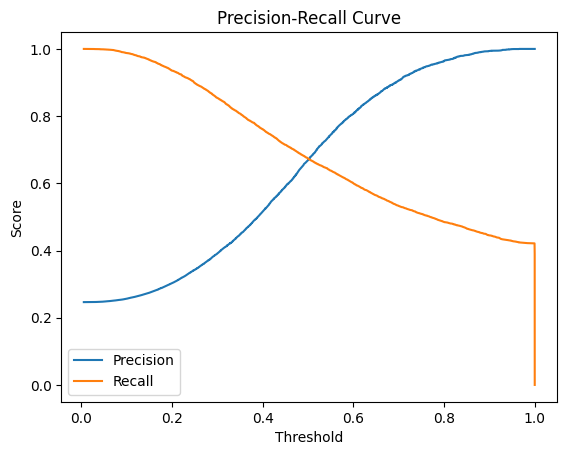

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Obtain predicted probabilities for the positive class (1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall values across different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot precision and recall as functions of the threshold
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Set threshold to 0.5 and calculate metrics
threshold = 0.5
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)  # Adjusted predictions with threshold 0.5

# Calculate metrics for threshold 0.5
print(f"Metrics for threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("Precision:", precision_score(y_test, y_pred_adjusted))
print("Recall:", recall_score(y_test, y_pred_adjusted))
print("F1 Score:", f1_score(y_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Optional: Calculate metrics for various thresholds in the range 0.44 - 0.5
thresholds = [0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_prob >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    print(f"\nMetrics for threshold {thresh}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Metriken für Schwelle 0.5:
Accuracy: 0.8374882653593407
Precision: 0.6692340008402184
Recall: 0.6739528980397688
F1 Score: 0.6715851602023609

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     21670
         1.0       0.67      0.67      0.67      7091

    accuracy                           0.84     28761
   macro avg       0.78      0.78      0.78     28761
weighted avg       0.84      0.84      0.84     28761


Metriken für Schwelle 0.44:
Precision: 0.5753255500673552
Recall: 0.7227471442673812
F1 Score: 0.6406650415650978

Metriken für Schwelle 0.45:
Precision: 0.5900570497147515
Recall: 0.7147087857847977
F1 Score: 0.6464285714285715

Metriken für Schwelle 0.46:
Precision: 0.6039508552156106
Recall: 0.7070934988012975
F1 Score: 0.6514649516013773

Metriken für Schwelle 0.47:
Precision: 0.6197975253093363
Recall: 0.6993371879847694
F1 Score: 0.6571693612509939

Metriken für Schwelle 0.48:
Precision: 0.63817

# 6. Model Selection and Evaluation

# 7. Saving the Best Model